# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                   
Sample_142  B0QY80;Q96HU1;Q96HU1-2              17.539
Sample_039  O95206;O95206-2                     14.774
Sample_206  P78539;P78539-2;P78539-3;P78539-5   15.361
Sample_039  Q9UBQ6                              17.847
Sample_190  K7ENA4;K7ESL8                       14.976
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                        
Sample_030  Q9BXP8                                    8.520
Sample_182  I3L397;I3L504;P63241;P63241-2             7.340
Sample_172  A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3   11.058
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.171
            A0A075B6Q5                 13.631
            A0A075B6R2                 13.195
            A0A075B6S5                 11.621
            A0A087WSY4                 11.908
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.963
            Q9UI40;Q9UI40-2            12.467
            Q9UIW2                     13.459
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.365
            Q9UP79                     12.965
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.308,15.050,16.842,19.863,12.718,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.937,19.067,...,15.528,15.576,12.783,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.948,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.631,17.705,17.039,14.331,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.161,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.216,15.345,17.084,18.708,14.249,19.433,10.729,9.559
Sample_207,15.739,16.877,15.469,16.898,14.936,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.187,13.117,11.612,13.733,11.166,13.256,13.352,12.925,12.232,12.943
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.174,19.067,16.127,...,13.401,13.189,12.948,12.407,14.095,11.986,11.879,14.102,13.145,12.937
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.936,13.210,13.672,12.329,12.125,11.840,13.849,11.627,12.764,13.491
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.069,13.842,11.873,13.302,12.108,13.628,14.075,12.636,13.070,12.672
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,14.075,13.553,12.985,13.003,12.534,12.349,13.254,12.696,13.358,13.690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.760,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 128.11it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.94it/s]

100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.82it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

100%|██████████| 4/4 [00:00<00:00,  3.88it/s]

100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.61it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.57it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.96it/s]

100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.73it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.27it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.04it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.09it/s]

100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.80it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.35it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.65it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.40it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.35it/s]

100%|██████████| 7/7 [00:01<00:00,  4.28it/s]

100%|██████████| 7/7 [00:01<00:00,  4.58it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.93it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.99it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.23it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.93it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.57it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.54it/s]

100%|██████████| 8/8 [00:01<00:00,  4.53it/s]

100%|██████████| 8/8 [00:01<00:00,  4.93it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.13it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.11it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.36it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.05it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.56it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.49it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.51it/s]

100%|██████████| 9/9 [00:01<00:00,  4.38it/s]

100%|██████████| 9/9 [00:01<00:00,  4.82it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.99it/s]

 30%|███       | 3/10 [00:00<00:01,  6.01it/s]

 40%|████      | 4/10 [00:00<00:01,  5.17it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.40it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.84it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.36it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.04it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.79it/s]

100%|██████████| 10/10 [00:02<00:00,  2.65it/s]

100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.71it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.37it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.71it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.38it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.25it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.10it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.05it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.90it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.75it/s]

100%|██████████| 11/11 [00:03<00:00,  2.66it/s]

100%|██████████| 11/11 [00:03<00:00,  3.11it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.46it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.12it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.70it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.05it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.92it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.35it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.10it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.06it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.16it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.08it/s]

100%|██████████| 12/12 [00:03<00:00,  2.98it/s]

100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.02it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.60it/s]

 31%|███       | 4/13 [00:00<00:02,  4.22it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.03it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.86it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.24it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.99it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.92it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.93it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.84it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.83it/s]

100%|██████████| 13/13 [00:03<00:00,  3.11it/s]

100%|██████████| 13/13 [00:03<00:00,  3.31it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.37it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.87it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.88it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.31it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.01it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.82it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.35it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.06it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.83it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.71it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.76it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.82it/s]

100%|██████████| 14/14 [00:04<00:00,  2.86it/s]

100%|██████████| 14/14 [00:04<00:00,  3.31it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.21it/s]

 20%|██        | 3/15 [00:00<00:02,  4.59it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.11it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.91it/s]

 40%|████      | 6/15 [00:01<00:02,  3.64it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.53it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.25it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.06it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.79it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.72it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.73it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.86it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.96it/s]

100%|██████████| 15/15 [00:04<00:00,  3.09it/s]

100%|██████████| 15/15 [00:04<00:00,  3.24it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.037 0.012          0.858 0.238       0.153   
2             0.004 0.004      0.052 0.019          0.666 0.115       0.512   
3             0.006 0.007      0.059 0.024          0.781 0.103       0.767   
4             0.004 0.003      0.039 0.014          0.801 0.094       0.774   
5             0.004 0.005      0.045 0.022          0.774 0.092       0.780   
6             0.005 0.006      0.042 0.019          0.773 0.092       0.774   
7             0.005 0.006      0.063 0.033          0.775 0.094       0.776   
8             0.007 0.009      0.059 0.022          0.810 0.096       0.791   
9             0.007 0.006      0.068 0.025          0.806 0.090       0.803   
10            0.005 0.005      0.053 0.024          0.803 0.090       0.803   
11            0.005 0.003      0.049 0.020          0.823 0.084       0.803   
12            0.006 0.006      0.046 0.020          0.830 0.083       0.803   
13            0.004 0.002      0.043 0.016          0.824 0.089       0.815   
14            0.004 0.001      0.043 0.016          0.818 0.084       0.815   
15            0.005 0.003      0.043 0.013          0.820 0.084       0.811   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.251 0.126                  0.568 0.043        0.851   
2          0.124   0.568 0.098                  0.659 0.062        0.726   
3          0.105   0.768 0.078                  0.802 0.065        0.882   
4          0.105   0.782 0.076                  0.814 0.062        0.887   
5          0.093   0.772 0.068                  0.804 0.058        0.893   
6          0.088   0.769 0.064                  0.801 0.054        0.891   
7          0.085   0.771 0.065                  0.803 0.055        0.890   
8          0.094   0.796 0.071                  0.825 0.060        0.911   
9          0.078   0.800 0.061                  0.828 0.053        0.910   
10         0.080   0.799 0.061                  0.826 0.053        0.908   
11         0.084   0.809 0.063                  0.836 0.054        0.921   
12         0.084   0.813 0.065                  0.840 0.055        0.920   
13         0.089   0.816 0.068                  0.842 0.058        0.920   
14         0.092   0.813 0.067                  0.840 0.056        0.919   
15         0.096   0.811 0.069                  0.839 0.058        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.089        210.000 0.000  
2          0.071                  0.675 0.082        210.000 0.000  
3          0.056                  0.843 0.083        210.000 0.000  
4          0.051                  0.855 0.074        210.000 0.000  
5          0.048                  0.856 0.069        210.000 0.000  
6          0.048                  0.854 0.070        210.000 0.000  
7          0.048                  0.852 0.070        210.000 0.000  
8          0.045                  0.888 0.058        210.000 0.000  
9          0.045                  0.890 0.058        210.000 0.000  
10         0.045                  0.889 0.058        210.000 0.000  
11         0.043                  0.910 0.047        210.000 0.000  
12         0.044                  0.907 0.051        210.000 0.000  
13         0.046                  0.905 0.053        210.000 0.000  
14         0.046                  0.905 0.053        210.000 0.000  
15         0.046                  0.903 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 541.41it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.36it/s]

100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.13it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.08it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.34it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.97it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.09it/s]

100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.97it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.32it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.64it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.26it/s]

100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.21it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.80it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.85it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.46it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.13it/s]

100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.66it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.87it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.40it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.08it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.98it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.93it/s]

100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.78it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.06it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.34it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.99it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.82it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.60it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.76it/s]

100%|██████████| 9/9 [00:02<00:00,  2.98it/s]

100%|██████████| 9/9 [00:02<00:00,  3.08it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.41it/s]

 30%|███       | 3/10 [00:00<00:01,  5.18it/s]

 40%|████      | 4/10 [00:00<00:01,  4.68it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.38it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.11it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.96it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.83it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.84it/s]

100%|██████████| 10/10 [00:02<00:00,  3.09it/s]

100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.51it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.48it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.95it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.95it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.00it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.01it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.10it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.14it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.39it/s]

100%|██████████| 11/11 [00:03<00:00,  3.17it/s]

100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.94it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.31it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.54it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.44it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.55it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.52it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.64it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.61it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.31it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

100%|██████████| 12/12 [00:03<00:00,  2.83it/s]

100%|██████████| 12/12 [00:03<00:00,  3.33it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.04it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.91it/s]

 31%|███       | 4/13 [00:01<00:03,  2.47it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.76it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.93it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.68it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.71it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.79it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.95it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.10it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.34it/s]

100%|██████████| 13/13 [00:04<00:00,  3.53it/s]

100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.31it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.86it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.61it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.27it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.77it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.57it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.45it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.44it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.52it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.51it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.61it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.65it/s]

100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.15it/s]

 20%|██        | 3/15 [00:00<00:03,  3.73it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.59it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.51it/s]

 40%|████      | 6/15 [00:01<00:02,  3.45it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.59it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.43it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.94it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.60it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.55it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.62it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.84it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.98it/s]

100%|██████████| 15/15 [00:04<00:00,  3.16it/s]

100%|██████████| 15/15 [00:04<00:00,  3.11it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.009      0.053 0.020          0.723 0.383       0.099   
2             0.005 0.004      0.046 0.015          0.703 0.090       0.603   
3             0.006 0.005      0.058 0.024          0.684 0.097       0.596   
4             0.005 0.004      0.053 0.020          0.762 0.097       0.628   
5             0.004 0.002      0.049 0.021          0.737 0.099       0.635   
6             0.004 0.002      0.037 0.011          0.715 0.102       0.665   
7             0.004 0.004      0.036 0.014          0.714 0.089       0.693   
8             0.003 0.000      0.036 0.008          0.719 0.101       0.681   
9             0.004 0.003      0.043 0.016          0.785 0.092       0.774   
10            0.005 0.005      0.050 0.022          0.803 0.086       0.794   
11            0.005 0.006      0.047 0.016          0.819 0.082       0.825   
12            0.004 0.002      0.048 0.017          0.813 0.090       0.824   
13            0.004 0.003      0.047 0.022          0.812 0.082       0.822   
14            0.008 0.007      0.074 0.034          0.818 0.081       0.835   
15            0.004 0.002      0.038 0.012          0.811 0.077       0.821   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.166 0.123                  0.542 0.038        0.850   
2          0.106   0.643 0.080                  0.707 0.059        0.784   
3          0.107   0.630 0.081                  0.694 0.061        0.778   
4          0.112   0.682 0.083                  0.740 0.062        0.800   
5          0.119   0.676 0.092                  0.733 0.068        0.800   
6          0.118   0.683 0.088                  0.733 0.068        0.805   
7          0.127   0.697 0.089                  0.744 0.068        0.815   
8          0.116   0.694 0.089                  0.741 0.071        0.818   
9          0.112   0.774 0.077                  0.807 0.065        0.889   
10         0.122   0.793 0.084                  0.824 0.070        0.894   
11         0.105   0.818 0.072                  0.845 0.062        0.903   
12         0.097   0.814 0.070                  0.841 0.061        0.905   
13         0.098   0.812 0.066                  0.840 0.057        0.906   
14         0.096   0.822 0.068                  0.848 0.059        0.906   
15         0.100   0.812 0.069                  0.840 0.060        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.824 0.088        210.000 0.000  
2          0.066                  0.760 0.085        210.000 0.000  
3          0.066                  0.748 0.083        210.000 0.000  
4          0.065                  0.775 0.085        210.000 0.000  
5          0.067                  0.773 0.087        210.000 0.000  
6          0.064                  0.777 0.084        210.000 0.000  
7          0.069                  0.781 0.092        210.000 0.000  
8          0.067                  0.774 0.093        210.000 0.000  
9          0.052                  0.863 0.063        210.000 0.000  
10         0.052                  0.870 0.060        210.000 0.000  
11         0.053                  0.889 0.058        210.000 0.000  
12         0.051                  0.890 0.059        210.000 0.000  
13         0.051                  0.893 0.060        210.000 0.000  
14         0.051                  0.894 0.060        210.000 0.000  
15         0.051                  0.892 0.060 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1040.00it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 31.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 19.66it/s]

100%|██████████| 4/4 [00:00<00:00, 18.38it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 26.40it/s]

100%|██████████| 5/5 [00:00<00:00, 21.29it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.00it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.95it/s]

100%|██████████| 6/6 [00:00<00:00, 15.27it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.47it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 19.07it/s]

100%|██████████| 7/7 [00:00<00:00, 17.37it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.89it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.70it/s]

100%|██████████| 8/8 [00:00<00:00, 14.27it/s]

100%|██████████| 8/8 [00:00<00:00, 14.69it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.10it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 15.73it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.92it/s]

100%|██████████| 9/9 [00:00<00:00, 15.04it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 25.53it/s]

 60%|██████    | 6/10 [00:00<00:00, 17.79it/s]

 80%|████████  | 8/10 [00:00<00:00, 16.64it/s]

100%|██████████| 10/10 [00:00<00:00, 15.97it/s]

100%|██████████| 10/10 [00:00<00:00, 16.90it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 23.47it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 18.56it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.62it/s]

 91%|█████████ | 10/11 [00:00<00:00, 15.67it/s]

100%|██████████| 11/11 [00:00<00:00, 16.46it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.18it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.64it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.45it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.42it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.19it/s]

100%|██████████| 12/12 [00:00<00:00, 13.59it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.83it/s]

 46%|████▌     | 6/13 [00:00<00:00, 20.36it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 17.22it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 16.60it/s]

100%|██████████| 13/13 [00:00<00:00, 15.58it/s]

100%|██████████| 13/13 [00:00<00:00, 16.76it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.86it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.22it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.21it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 15.96it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.23it/s]

100%|██████████| 14/14 [00:00<00:00, 15.77it/s]

100%|██████████| 14/14 [00:00<00:00, 16.16it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.67it/s]

 33%|███▎      | 5/15 [00:00<00:00, 16.34it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.23it/s]

 60%|██████    | 9/15 [00:00<00:00, 14.98it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 14.90it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 15.22it/s]

100%|██████████| 15/15 [00:01<00:00, 13.52it/s]

100%|██████████| 15/15 [00:01<00:00, 14.39it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.042 0.019          0.203 0.395       0.014   
2             0.003 0.001      0.025 0.007          0.668 0.250       0.175   
3             0.003 0.002      0.040 0.015          0.637 0.219       0.204   
4             0.004 0.002      0.042 0.014          0.620 0.191       0.285   
5             0.003 0.002      0.034 0.007          0.588 0.182       0.280   
6             0.005 0.005      0.039 0.013          0.548 0.106       0.412   
7             0.004 0.003      0.044 0.018          0.543 0.101       0.422   
8             0.007 0.006      0.059 0.027          0.566 0.108       0.437   
9             0.004 0.003      0.046 0.016          0.561 0.110       0.438   
10            0.005 0.004      0.064 0.024          0.557 0.114       0.438   
11            0.004 0.003      0.037 0.009          0.551 0.110       0.432   
12            0.004 0.003      0.044 0.014          0.571 0.122       0.470   
13            0.006 0.005      0.056 0.020          0.569 0.127       0.466   
14            0.006 0.005      0.059 0.022          0.568 0.121       0.481   
15            0.004 0.002      0.044 0.016          0.550 0.108       0.465   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.026 0.050                  0.505 0.014        0.715   
2          0.085   0.263 0.110                  0.549 0.041        0.629   
3          0.068   0.295 0.077                  0.543 0.052        0.612   
4          0.091   0.379 0.102                  0.568 0.067        0.602   
5          0.098   0.367 0.099                  0.559 0.062        0.600   
6          0.102   0.464 0.090                  0.579 0.068        0.665   
7          0.102   0.469 0.089                  0.579 0.067        0.661   
8          0.097   0.487 0.086                  0.592 0.067        0.665   
9          0.098   0.485 0.086                  0.590 0.069        0.658   
10         0.103   0.484 0.091                  0.588 0.071        0.652   
11         0.100   0.479 0.090                  0.585 0.070        0.646   
12         0.103   0.509 0.097                  0.601 0.080        0.666   
13         0.107   0.505 0.098                  0.599 0.080        0.658   
14         0.115   0.513 0.099                  0.602 0.080        0.672   
15         0.103   0.497 0.087                  0.589 0.071        0.662   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.072                  0.671 0.081        210.000 0.000  
2          0.102                  0.612 0.097        210.000 0.000  
3          0.103                  0.588 0.101        210.000 0.000  
4          0.099                  0.571 0.097        210.000 0.000  
5          0.096                  0.557 0.092        210.000 0.000  
6          0.083                  0.634 0.091        210.000 0.000  
7          0.083                  0.628 0.092        210.000 0.000  
8          0.083                  0.629 0.089        210.000 0.000  
9          0.083                  0.624 0.086        210.000 0.000  
10         0.083                  0.615 0.085        210.000 0.000  
11         0.086                  0.611 0.086        210.000 0.000  
12         0.084                  0.632 0.090        210.000 0.000  
13         0.084                  0.622 0.090        210.000 0.000  
14         0.084                  0.628 0.093        210.000 0.000  
15         0.086                  0.620 0.096 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,14,8
score_time,9,14,10
test_precision,1,11,2
test_recall,14,14,14
test_f1,13,14,14
test_balanced_accuracy,13,14,14
test_roc_auc,11,13,1
test_average_precision,11,14,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.12it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.78it/s]

 31%|███       | 4/13 [00:00<00:01,  4.92it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.50it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.36it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.22it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.91it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.20it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.69it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.39it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.27it/s]

100%|██████████| 13/13 [00:04<00:00,  2.20it/s]

100%|██████████| 13/13 [00:04<00:00,  3.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1180.83it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.52it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.68it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.75it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.61it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.46it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.54it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.52it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.39it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.42it/s]

100%|██████████| 11/11 [00:02<00:00,  3.94it/s]

100%|██████████| 11/11 [00:02<00:00,  4.48it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


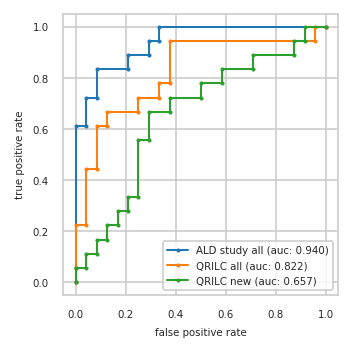

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.611     0.000 0.222     0.042 0.056
3          0.042 0.611     0.042 0.222     0.042 0.111
4          0.042 0.722     0.042 0.444     0.083 0.111
5          0.083 0.722     0.083 0.444     0.083 0.167
6          0.083 0.833     0.083 0.611     0.125 0.167
7          0.208 0.833     0.125 0.611     0.125 0.222
8          0.208 0.889     0.125 0.667     0.167 0.222
9          0.292 0.889     0.250 0.667     0.167 0.278
10         0.292 0.944     0.250 0.722     0.208 0.278
11         0.333 0.944     0.333 0.722     0.208 0.333
12         0.333 1.000     0.333 0.778     0.250 0.333
13         1.000 1.000     0.375 0.778     0.250 0.556
14           NaN   NaN     0.375 0.944     0.292 0.556
15           NaN   NaN     0.958 0.944     0.292 0.667
16           NaN   NaN     0.958 1.000     0.375 0.667
17           NaN   NaN     1.000 1.000     0.375 0.722
18           NaN   NaN       NaN   NaN     0.500 0.722
19           NaN   NaN       NaN   NaN     0.500 0.778
20           NaN   NaN       NaN   NaN     0.583 0.778
21           NaN   NaN       NaN   NaN     0.583 0.833
22           NaN   NaN       NaN   NaN     0.708 0.833
23           NaN   NaN       NaN   NaN     0.708 0.889
24           NaN   NaN       NaN   NaN     0.875 0.889
25           NaN   NaN       NaN   NaN     0.875 0.944
26           NaN   NaN       NaN   NaN     0.917 0.944
27           NaN   NaN       NaN   NaN     0.917 1.000
28           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,P10644;P10644-2
1,Q9NZ53,A0A0B4J1V0,None
2,Q92743,Q9Y2T3;Q9Y2T3-3,None
3,P04075,P60709;P63261,None
4,Q16674;W4VSR3,P61981,None
5,P61981,A0A0A0MRJ7;P12259,None
6,P14174,P04075,None
7,P08294,P14174,None
8,Q9Y2T3;Q9Y2T3-3,P00338;P00338-3,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


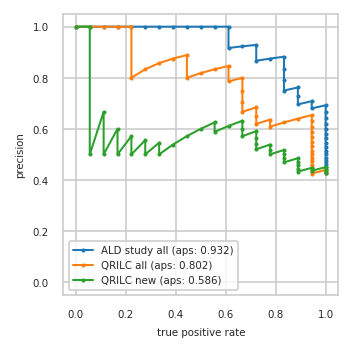

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.425 0.944     0.450 1.000
3          0.462 1.000     0.436 0.944     0.436 0.944
4          0.474 1.000     0.447 0.944     0.447 0.944
5          0.486 1.000     0.459 0.944     0.432 0.889
6          0.500 1.000     0.472 0.944     0.444 0.889
7          0.514 1.000     0.486 0.944     0.457 0.889
8          0.529 1.000     0.500 0.944     0.471 0.889
9          0.545 1.000     0.515 0.944     0.485 0.889
10         0.562 1.000     0.531 0.944     0.469 0.833
11         0.581 1.000     0.548 0.944     0.484 0.833
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.643 1.000     0.607 0.944     0.500 0.778
15         0.667 1.000     0.630 0.944     0.519 0.778
16         0.692 1.000     0.654 0.944     0.538 0.778
17         0.680 0.944     0.640 0.889     0.520 0.722
18         0.708 0.944     0.625 0.833     0.542 0.722
19         0.696 0.889     0.609 0.778     0.565 0.722
20         0.727 0.889     0.636 0.778     0.591 0.722
21         0.762 0.889     0.619 0.722     0.571 0.667
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.789 0.833     0.684 0.722     0.632 0.667
24         0.833 0.833     0.667 0.667     0.611 0.611
25         0.882 0.833     0.706 0.667     0.588 0.556
26         0.875 0.778     0.750 0.667     0.625 0.556
27         0.867 0.722     0.800 0.667     0.600 0.500
28         0.929 0.722     0.786 0.611     0.571 0.444
29         0.923 0.667     0.846 0.611     0.538 0.389
30         0.917 0.611     0.833 0.556     0.500 0.333
31         1.000 0.611     0.818 0.500     0.545 0.333
32         1.000 0.556     0.800 0.444     0.500 0.278
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


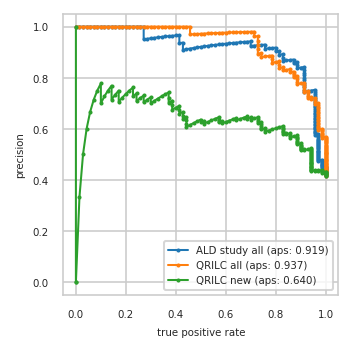

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


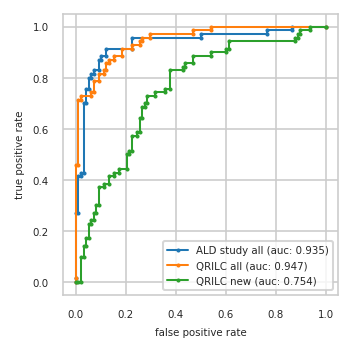

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}